In [1]:
!pip install -U scikit-learn
!pip install autograd

# 1st Assignment: NN's from Scratch

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

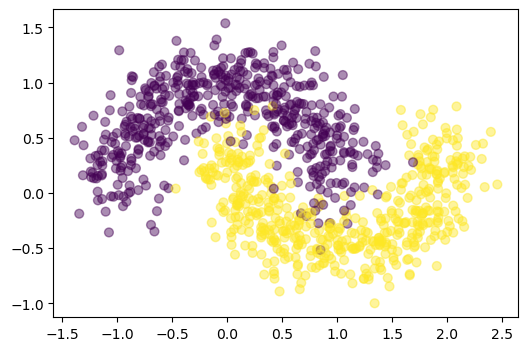

In [2]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)

# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

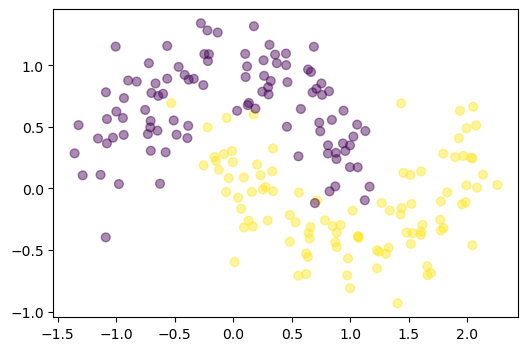

In [3]:
# Generate a testing dataset and plot it
np.random.seed(0)
Xt, yt = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(Xt[:,0], Xt[:,1], s=40, c=yt, alpha=0.45)

In [4]:
X[1], X.shape

(array([1.80460944, 0.00695963]), (1000, 2))

In [5]:
y[1], y.shape

(1, (1000,))

## Classification

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

+ The number of nodes in the input layer will be determined by the dimensionality of our data (2). 
+ Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 


If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ \hat{y} = \mbox{softmax}({z_2})$$

where $\hat{y}$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

## Softmax

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

## Cross-entropy loss

A common choice with the softmax output is the **cross-entropy loss**. 

If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

In [7]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [8]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.578993
Loss after iteration 1000: 0.318070
Loss after iteration 2000: 0.297688
Loss after iteration 3000: 0.292829
Loss after iteration 4000: 0.289559
Loss after iteration 5000: 0.286088
Loss after iteration 6000: 0.281947
Loss after iteration 7000: 0.276860
Loss after iteration 8000: 0.270635
Loss after iteration 9000: 0.263206
Loss after iteration 10000: 0.254674
Loss after iteration 11000: 0.245306
Loss after iteration 12000: 0.235476
Loss after iteration 13000: 0.225571
Loss after iteration 14000: 0.215925
Loss after iteration 15000: 0.206780
Loss after iteration 16000: 0.198287
Loss after iteration 17000: 0.190518
Loss after iteration 18000: 0.183483
Loss after iteration 19000: 0.177156
Loss after iteration 20000: 0.171486
Loss after iteration 21000: 0.166413
Loss after iteration 22000: 0.161872
Loss after iteration 23000: 0.157801
Loss after iteration 24000: 0.154141
Loss after iteration 25000: 0.150836
Loss after iteration 26000: 0.147835
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

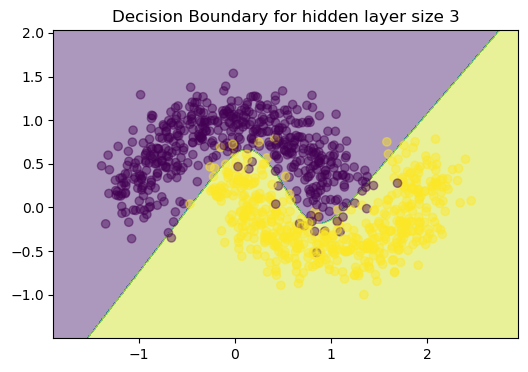

In [9]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x),X,y)
plt.title("Decision Boundary for hidden layer size 3")

# Exercise 1

+ Report the classification accuracy using the testing dataset.

In [10]:
# your code here
print(f"Train accuracy: {sklearn.metrics.accuracy_score(y, predict(model, X))}")

print(f"Test accuracy: {sklearn.metrics.accuracy_score(yt, predict(model, Xt))}")

Train accuracy: 0.962
Test accuracy: 0.955


Text(0.5, 1.0, 'Decision Boundary for TEST')

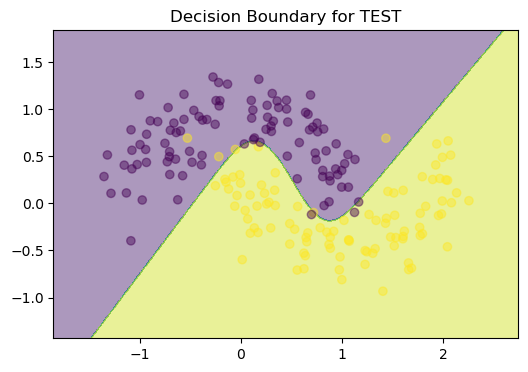

In [11]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x),Xt,yt)
plt.title("Decision Boundary for TEST")

#### Comments
Obviously the test error always has to be equal or higher than the training error. A 95% accuracy is quite good keeping in mind it has some indivisble poins, as we can see in the image due to the randomness.

# Exercise 2

+ Add an additional layer to your neural network model. 
+ Change the activation function and use a ReLU. 


In [12]:
nn_input_dim, nn_output_dim

(2, 2)

In [13]:
def ReLU(x):
  return np.maximum(0,x)


In [14]:
# your code here
# loss function for a 4-layer MLP
def loss2(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'],model['W3'], model['b3'] 
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict2(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'],model['W3'], model['b3'] 
    z1 = np.dot(x,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3

    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [15]:
def build_model2(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))
    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict2(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss2)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss2(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model2 = build_model2(3, num_passes=25000, print_loss=True)

Loss after iteration 0: 0.608797
Loss after iteration 1000: 0.311775
Loss after iteration 2000: 0.298420
Loss after iteration 3000: 0.288472
Loss after iteration 4000: 0.282411
Loss after iteration 5000: 0.278174
Loss after iteration 6000: 0.274442
Loss after iteration 7000: 0.271007
Loss after iteration 8000: 0.267987
Loss after iteration 9000: 0.265382
Loss after iteration 10000: 0.263243
Loss after iteration 11000: 0.261471
Loss after iteration 12000: 0.259814
Loss after iteration 13000: 0.258426
Loss after iteration 14000: 0.257259
Loss after iteration 15000: 0.256271
Loss after iteration 16000: 0.255432
Loss after iteration 17000: 0.254715
Loss after iteration 18000: 0.254071
Loss after iteration 19000: 0.253494
Loss after iteration 20000: 0.252974
Loss after iteration 21000: 0.252542
Loss after iteration 22000: 0.252180
Loss after iteration 23000: 0.251862
Loss after iteration 24000: 0.251596


In [16]:
print(f"Train accuracy: {sklearn.metrics.accuracy_score(y, predict2(model2, X))}")

print(f"Test accuracy: {sklearn.metrics.accuracy_score(yt, predict2(model2, Xt))}")


Train accuracy: 0.887
Test accuracy: 0.86


Text(0.5, 1.0, 'Decision Boundary for 4L MLP')

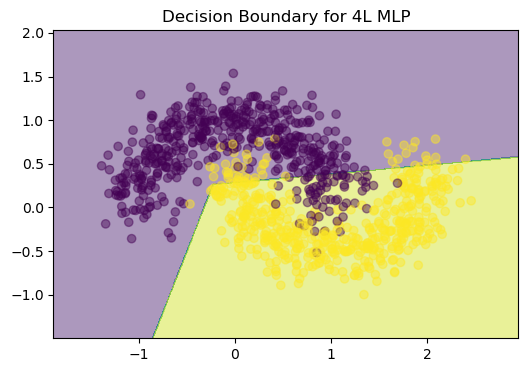

In [17]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict2(model2, x),X,y)
plt.title("Decision Boundary for 4L MLP")

Text(0.5, 1.0, 'Decision Boundary for TEST')

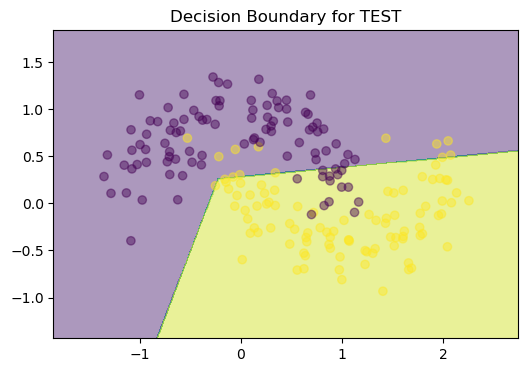

In [18]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict2(model2, x),Xt,yt)
plt.title("Decision Boundary for TEST")

Let's try to add more neurons in our hidden layers!

Loss after iteration 0: 0.753682
Loss after iteration 1000: 0.294607
Loss after iteration 2000: 0.266678
Loss after iteration 3000: 0.242473
Loss after iteration 4000: 0.215471
Loss after iteration 5000: 0.181871
Loss after iteration 6000: 0.152003
Loss after iteration 7000: 0.130294
Loss after iteration 8000: 0.116161
Loss after iteration 9000: 0.107345
Loss after iteration 10000: 0.101549
Loss after iteration 11000: 0.097495
Loss after iteration 12000: 0.094696
Loss after iteration 13000: 0.092480
Loss after iteration 14000: 0.090622
Loss after iteration 15000: 0.089122
Loss after iteration 16000: 0.088056
Loss after iteration 17000: 0.087162
Loss after iteration 18000: 0.086550
Loss after iteration 19000: 0.086105
Loss after iteration 20000: 0.085740
Loss after iteration 21000: 0.085447
Loss after iteration 22000: 0.085196
Loss after iteration 23000: 0.084976
Loss after iteration 24000: 0.084777


Text(0.5, 1.0, 'Decision Boundary for 4L MLP with 8neurons')

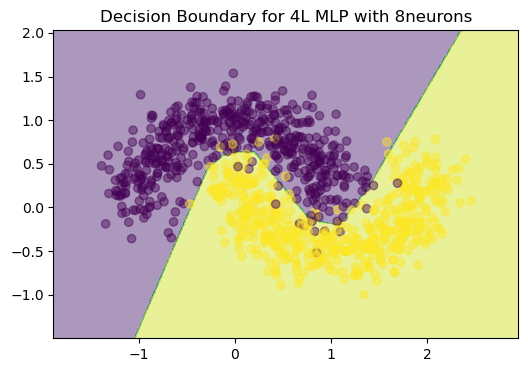

In [19]:
model3 = build_model2(8, num_passes=25000, print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict2(model3, x),X,y)
plt.title("Decision Boundary for 4L MLP with 8neurons")

In [20]:
print(f"Train accuracy: {sklearn.metrics.accuracy_score(y, predict2(model3, X))}")

print(f"Test accuracy: {sklearn.metrics.accuracy_score(yt, predict2(model3, Xt))}")


Train accuracy: 0.969
Test accuracy: 0.975


#### Comments
A really good improvement just adding 5 more neurons per layer. In this case, this addition has helped us to model a more complex boundary.

We could try to minimize even more the error with more layers, the fact is that as we just randomly generated our dataset, it seems that there are purple points which are mixed with yellow points. Hence, and once we have understood and visualized this, it can be thought that a further improvement will be really hard.

It is also important to see how the first experiment using ReLu and 2 hidden layer, the boundaries seem to be "linear", in the sense of not fitting the curves. Might be because of the ReLu function itself which has this linear behaviour and without complexity may not adapt to strange patterns.

# Exercise 3

+ Design your own model (layers, activation function, number of units per layer, etc.) and train it to classify the following dataset. 
+ Train the model and report the classification accuracy using the testing dataset.


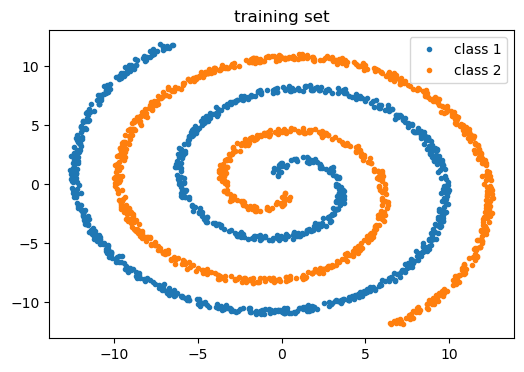

In [33]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

X, y = twospirals(1000)

plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [22]:
# your code here
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
# Gradient descent parameters 
epsilon = 0.01 # learning rate for gradient descent

In [49]:
def loss_spiral(model):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5'],model['W6'], model['b6'] 
    
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = ReLU(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = ReLU(z4)
    z5 = np.dot(a4,W5) + b5
    a5 = ReLU(z5)
    z6 = np.dot(a5,W6) + b6
    
    exp_scores = np.exp(z6)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y.astype(int)])
    data_loss = np.sum(corect_logprobs)
    
    return 1./num_examples * data_loss

# forward propagation
def predict_spiral(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4'], model['W5'], model['b5'],model['W6'], model['b6'] 
    
    z1 = np.dot(x,W1) + b1
    a1 = ReLU(z1)
    z2 = np.dot(a1,W2) + b2
    a2 = ReLU(z2)
    z3 = np.dot(a2,W3) + b3
    a3 = ReLU(z3)
    z4 = np.dot(a3,W4) + b4
    a4 = ReLU(z4)
    z5 = np.dot(a4,W5) + b5
    a5 = ReLU(z5)
    z6 = np.dot(a5,W6) + b6
    
    exp_scores = np.exp(z6)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [37]:
def build_mmodel_spiral(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(42)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) # 1st Layer
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim) 
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_hdim))
    W4 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b4 = np.zeros((1, nn_hdim))
    W5 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b5 = np.zeros((1, nn_hdim))
    W6 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b6 = np.zeros((1, nn_output_dim))
    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5, 'W6': W6, 'b6': b6}
    

    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict_spiral(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss_spiral)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss_spiral(model)))
    
    return model

In [38]:
# Build a model with a 16-dimensional 6 hidden layers. 
model3 = build_mmodel_spiral(16, num_passes=35000, print_loss=True)

Loss after iteration 0: 0.809956
Loss after iteration 1000: 0.645658
Loss after iteration 2000: 0.635948
Loss after iteration 3000: 0.626411
Loss after iteration 4000: 0.614515
Loss after iteration 5000: 0.601240
Loss after iteration 6000: 0.588502
Loss after iteration 7000: 0.572781
Loss after iteration 8000: 0.554596
Loss after iteration 9000: 0.519772
Loss after iteration 10000: 0.469527
Loss after iteration 11000: 0.405949
Loss after iteration 12000: 0.316815
Loss after iteration 13000: 0.462576
Loss after iteration 14000: 0.320826
Loss after iteration 15000: 0.717586
Loss after iteration 16000: 0.148876
Loss after iteration 17000: 0.077549
Loss after iteration 18000: 0.035455
Loss after iteration 19000: 0.020001
Loss after iteration 20000: 0.013445
Loss after iteration 21000: 0.009330
Loss after iteration 22000: 0.007050
Loss after iteration 23000: 0.005553
Loss after iteration 24000: 0.004428
Loss after iteration 25000: 0.003634
Loss after iteration 26000: 0.003050
Loss after ite

Observe how the model struggles to learn the correct behaviour of the model. It is not until a few thousand of them when the model starts fitting the data very quickly. 

Is it also interesting to analyze how many iterations ara completely necessary. In this case, we see that after the iteration 20000 approximately, the model loss is below 0.01, maybe cutting here might be enough.

In [51]:
X_test.shape, y_test.shape, predict_spiral(model3, X_test).shape

((400, 2), (400,), (400,))

In [52]:
X_test, y_test = twospirals(200)
print(f"Train accuracy: {sklearn.metrics.accuracy_score(y, predict_spiral(model3, X))}")

print(f"Test accuracy: {sklearn.metrics.accuracy_score(y_test, predict_spiral(model3, X_test))}")


Train accuracy: 1.0
Test accuracy: 1.0


Text(0.5, 1.0, 'Decision Boundary for Training - 6 layers w/ 16 neurons. ReLu')

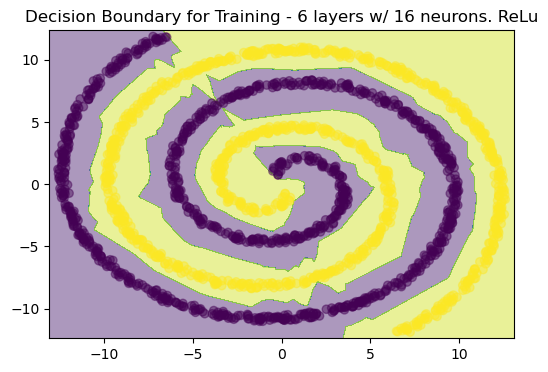

In [53]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict_spiral(model3, x),X,y)
plt.title("Decision Boundary for Training - 6 layers w/ 16 neurons. ReLu")

Text(0.5, 1.0, 'Decision Boundary for Testing - 6 layers w/ 16 neurons. ReLu')

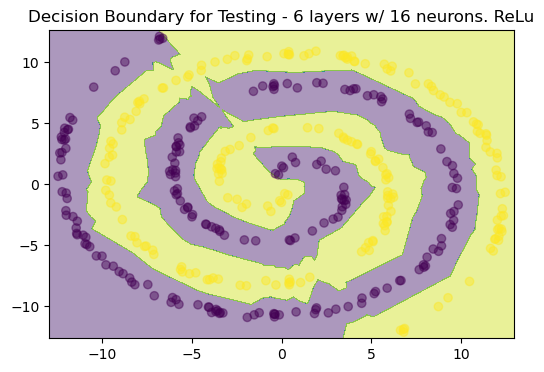

In [54]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict_spiral(model3, x),X_test,y_test)
plt.title("Decision Boundary for Testing - 6 layers w/ 16 neurons. ReLu")

Nice! It seems that we are perfectly classifying all the examples. Not only are we precisely classifying training set, but also the test one. However, and maybe I'm wrong, but I do not like the upper boundary for the purple class, looks like it won't be able to generalize well. For this reason, I would like to try another approach and see if other combinations make things more smoothly.

Loss after iteration 0: 0.758417
Loss after iteration 1000: 0.664012
Loss after iteration 2000: 0.654321
Loss after iteration 3000: 0.647909
Loss after iteration 4000: 0.640307
Loss after iteration 5000: 0.634042
Loss after iteration 6000: 0.627761
Loss after iteration 7000: 0.622781
Loss after iteration 8000: 0.617997
Loss after iteration 9000: 0.613402
Loss after iteration 10000: 0.607944
Loss after iteration 11000: 0.603164
Loss after iteration 12000: 0.598550
Loss after iteration 13000: 0.593768
Loss after iteration 14000: 0.589530
Loss after iteration 15000: 0.590825
Loss after iteration 16000: 0.579629
Loss after iteration 17000: 0.570422
Loss after iteration 18000: 0.557562
Loss after iteration 19000: 0.541507
Loss after iteration 20000: 0.515825
Loss after iteration 21000: 0.477537
Loss after iteration 22000: 0.404002
Loss after iteration 23000: 0.266339
Loss after iteration 24000: 0.182780
Loss after iteration 25000: 0.116694
Loss after iteration 26000: 0.053905
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for Training - 6 layers w/ 8 neurons. ReLu')

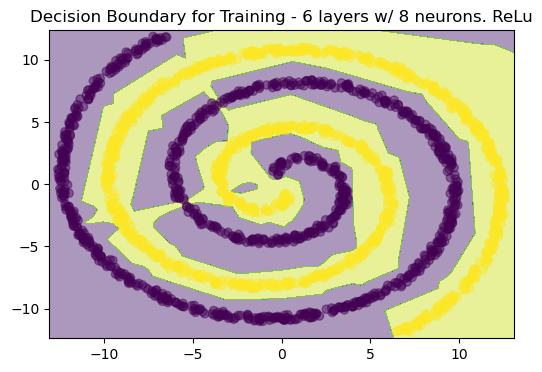

In [56]:
# Build a model with a 16-dimensional 6 hidden layers. 
model4 = build_mmodel_spiral(8, num_passes=35000, print_loss=True)
# Plot the decision boundary
plot_decision_boundary(lambda x: predict_spiral(model4, x),X,y)
plt.title("Decision Boundary for Training - 6 layers w/ 8 neurons. ReLu")

Text(0.5, 1.0, 'Decision Boundary for Testing - 6 layers w/ 16 neurons. ReLu')

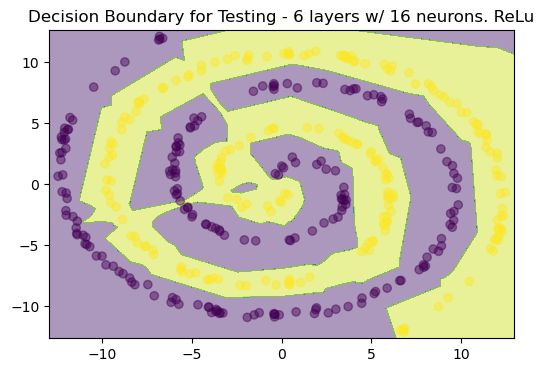

In [57]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict_spiral(model4, x),X_test,y_test)
plt.title("Decision Boundary for Testing - 6 layers w/ 16 neurons. ReLu")

In [58]:
X_test, y_test = twospirals(200)
print(f"Train accuracy: {sklearn.metrics.accuracy_score(y, predict_spiral(model4, X))}")

print(f"Test accuracy: {sklearn.metrics.accuracy_score(y_test, predict_spiral(model4, X_test))}")


Train accuracy: 0.999
Test accuracy: 0.9975


#### Comments
Both results are quite good ones. In the first one, with 4 hidden layers and 16 neuros per layer, we can see how the NN fit perfectly the data, and this might have something called overfitting. What made me try another configuration was the upper-left boundary, where the yellow one seems to be extremely fitting the data, because it will not be able to generalize for the next purple points for example. 

On the other hand, the second example might be generalizing better than the first one but has some strange unions which make it has a little error. All in all, I prefer this one :) 